In [1]:
import sys

In [2]:
sys.path.insert(0, '/data/hsiming/github/keras-retinanet/keras_retinanet/')

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow import keras

In [4]:
from preprocessing.csv_generator import CSVGenerator
from utils.compute_overlap import compute_overlap

Using TensorFlow backend.


In [5]:
batch_size = 1
group_index = 2
input_shape = (800, 800)
num_classes = 1
scale = 800.0/1024.0

## Create generator

In [6]:
import pandas as pd

In [7]:
#df = pd.read_csv('train.csv', names=['img', 'x1', 'y1', 'x2', 'y2', 'label'])
#df[df['label'].notna()].to_csv('train_positive.csv', index=False, header=False, float_format='%d')

In [8]:
train_generator = CSVGenerator(
    'train_positive.csv',
    'classes.csv',
    batch_size=batch_size,
    transform_generator=None)

## Raw data 1024 x 1024

In [9]:
group = train_generator.groups[group_index]
print(group)

[220]


In [10]:
img_group = [train_generator.load_image(image_index) for image_index in group]
gt_group = [train_generator.load_annotations(image_index) for image_index in group]

In [11]:
gt_group

[{'labels': array([0., 0.]), 'bboxes': array([[159., 152., 389., 695.],
         [518., 179., 801., 731.]])}]

In [12]:
assert len(img_group) == len(gt_group)
img = img_group[0]
gt = gt_group[0]
old_gt = gt['bboxes']
print(old_gt)
gt['bboxes'] *= scale

[[159. 152. 389. 695.]
 [518. 179. 801. 731.]]


{'labels': array([0., 0.]), 'bboxes': array([[124.21875, 118.75   , 303.90625, 542.96875],
       [404.6875 , 139.84375, 625.78125, 571.09375]])}


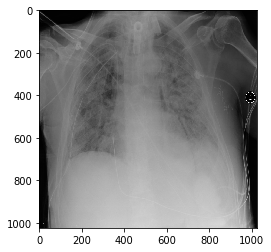

In [13]:
plt.figure()
plt.imshow(img, cmap='gray')
print(gt)

/data/hsiming/dataset/kaggle_pneumonia_stage2_train/PNG/6f3d76ce-9c4e-4e4c-b344-776d764e1be8.png


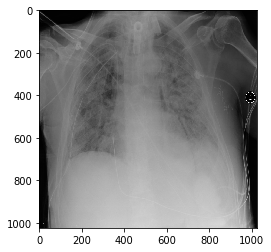

In [14]:
img_path = train_generator.image_names[group[0]]
img = cv2.imread(img_path)
plt.figure()
plt.imshow(img, cmap='gray')
print(img_path)

## Data from generator.\_\_getitem\_\_

In [15]:
img, [bbox, label] = train_generator.__getitem__(group_index)

In [16]:
assert img.shape == (1, 800, 800, 3)
assert label.shape == (1, 120087, 2)
assert bbox.shape == (1, 120087, 5)

In [17]:
print('positive anchors: {:.0f}'.format(label[0][:, 0].sum()))

positive anchors: 44


In [18]:
x = np.empty((800, 800, 3))
x[..., 0] = img[0, :, :, 0] + 103.939
x[..., 1] = img[0, :, :, 1] + 116.779
x[..., 2] = img[0, :, :, 2] + 123.68
x = x.astype(np.uint8)

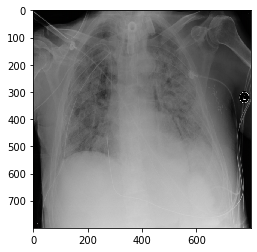

In [19]:
plt.figure()
plt.imshow(x)

## Anchors

In [20]:
class AnchorParameters:
    """ The parameteres that define how anchors are generated.

    Args
        sizes   : List of sizes to use. Each size corresponds to one feature level.
        strides : List of strides to use. Each stride correspond to one feature level.
        ratios  : List of ratios to use per location in a feature map.
        scales  : List of scales to use per location in a feature map.
    """
    def __init__(self, sizes, strides, ratios, scales):
        assert len(sizes) == len(strides) 
        
        self.sizes   = sizes
        self.strides = strides
        self.ratios  = ratios
        self.scales  = scales

    def num_anchors(self):
        return len(self.ratios) * len(self.scales)

In [21]:
AnchorParameters.default = AnchorParameters(
    sizes   = [32, 64, 128, 256, 512],
    strides = [8, 16, 32, 64, 128],
    ratios  = np.array([0.5, 1, 2], keras.backend.floatx()),
    scales  = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx()),
)

In [22]:
anchor_params = AnchorParameters.default
assert anchor_params.num_anchors() == 9
anchor_params.levels = [3, 4, 5, 6, 7]
assert len(np.unique([len(anchor_params.levels), len(anchor_params.sizes), len(anchor_params.strides)])) == 1

### guess_shape()

In [23]:
def guess_shapes(image_shape, pyramid_levels):
    """Guess shapes based on pyramid levels.

    Args
         image_shape: The shape of the image.
         pyramid_levels: A list of what pyramid levels are used.

    Returns
        A list of image shapes at each pyramid level.
    """
    image_shape = np.array(image_shape[:2])
    image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in pyramid_levels]
    #image_shapes = [np.ceil(image_shape / (2 ** x)) for x in pyramid_levels]
    
    return image_shapes

In [24]:
def tf_feature_shapes(image_shape, pyramid_levels):
    """Guess shapes based on pyramid levels.

    Args
        pyramid_levels: A list of what pyramid levels are used.

    Returns
        A list of image shapes at each pyramid level.
    """
    
    image_shape = tf.expand_dims(image_shape, 0)
    scales = tf.expand_dims(tf.pow(2, pyramid_levels), 1)
    feature_shapes = tf.math.ceil(image_shape / scales)
    
    return feature_shapes

In [25]:
input_shape

(800, 800)

In [26]:
anchor_params.levels

[3, 4, 5, 6, 7]

In [27]:
tf_image_shapes = tf_feature_shapes(input_shape, anchor_params.levels)

In [28]:
np_image_shapes = guess_shapes(input_shape, anchor_params.levels)
assert np.array_equal(tf_image_shapes, np_image_shapes)

### generate_anchors()


Generate anchors w.r.t. origin given anchor base_length

In [29]:
def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    base_size
    
    
    if ratios is None:
        ratios = AnchorParameters.default.ratios

    if scales is None:
        scales = AnchorParameters.default.scales

    num_anchors = len(ratios) * len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T
    
    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]

    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))
    
    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

In [30]:
def tf_generate_anchors(base_sizes, scales, ratios):
    """ Generate anchor (reference) windows w.r.t. origin.
    
    Args
        base_sizes: np.array of anchor lengths.
        scales: Different scales given one anchor length.
        ratios: Different hieght/width ratios given fixed anchor area.

    Returns
        anchors: Tensor of shape (len(base_sizes), len(scales) * len(ratios), 4).
    """
    base_sizes = tf.cast(base_sizes, dtype=tf.float64)
    scales = tf.cast(scales, dtype=tf.float64)
    ratios = tf.cast(ratios, dtype=tf.float64)
    
    with tf.control_dependencies([tf.assert_rank(base_sizes, 1),
                                  tf.assert_rank(scales, 1), 
                                  tf.assert_rank(ratios, 1)]):
        num_sizes = tf.shape(base_sizes)[0]
        num_scales = tf.shape(scales)[0]
        num_ratios = tf.shape(ratios)[0]
    
    base_sizes = tf.expand_dims(base_sizes, -1)
    scales = tf.expand_dims(scales, 0)
    
    sizes = tf.multiply(base_sizes, scales)
    sizes = tf.tile(sizes, [1, num_ratios])
    sizes = tf.reshape(sizes, [num_sizes, -1, 1])
    
    ratios = tf.sqrt(ratios)
    ratios = tf.tile(tf.expand_dims(ratios, 1), [1, num_scales])
    ratios = tf.tile(ratios, [num_sizes, 1])
    ratios = tf.reshape(ratios, [num_sizes, -1, 1])
    ratios = tf.concat([tf.math.reciprocal(ratios), ratios], axis=2)
    
    # all possible widths and heights
    width_height = tf.multiply(sizes, ratios)
    
    # [xmax, ymax]
    max_grid = 0.5 * width_height
    
    # [xmin, ymin]
    min_grid = - max_grid

    # [xmin, ymin, xmax, ymax]
    anchors = tf.concat([min_grid, max_grid], axis=2)
    
    return anchors

In [31]:
tf_anchors = tf_generate_anchors(anchor_params.sizes, anchor_params.scales, anchor_params.ratios)

In [32]:
np_anchors = np.zeros((0, anchor_params.num_anchors(), 4))
for size in anchor_params.sizes:
    a = generate_anchors(base_size=size, ratios=anchor_params.ratios, scales=anchor_params.scales)
    a = np.expand_dims(a, axis=0)
    np_anchors = np.append(np_anchors, a, axis=0)

In [33]:
assert np.allclose(tf_anchors, np_anchors)

### shift()

In [34]:
def np_shift(shape, stride, anchors):
    """ Produce shifted anchors based on shape of the map and stride size.

    Args
        shape  : Shape to shift the anchors over.
        stride : Stride to shift the anchors with over the shape.
        anchors: The anchors to apply at each location.
    """

    # create a grid starting from half stride from the top left corner
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()
    
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((K, 1, 4)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors

In [35]:
# def anchors_for_shape
# compute anchors over all pyramid levels
np_all_anchors = np.zeros((0, 4))
for idx, p in enumerate(anchor_params.levels):
    anchors = generate_anchors(
        base_size=anchor_params.sizes[idx],
        ratios=anchor_params.ratios,
        scales=anchor_params.scales
    )
    shifted_anchors = np_shift(np_image_shapes[idx], anchor_params.strides[idx], anchors)
    print('shifted_anchors shape: {}'.format(shifted_anchors.shape))
    np_all_anchors = np.append(np_all_anchors, shifted_anchors, axis=0)

shifted_anchors shape: (90000, 4)
shifted_anchors shape: (22500, 4)
shifted_anchors shape: (5625, 4)
shifted_anchors shape: (1521, 4)
shifted_anchors shape: (441, 4)


In [36]:
def tf_shift(map_shape, stride, anchors):
    """ Produce shifted anchors based on shape of the map and stride size.

    Args
        map_shape: Feature map height and width of shape (num_levels, 2)
        stride: Stride to shift the anchors with over the shape.
        anchors: The anchors to apply at each location.
    """
    map_shape = tf.cast(map_shape, dtype=tf.float64)
    stride = tf.cast(stride, dtype=tf.float64)
    
    map_area = tf.reduce_prod(map_shape, axis=0)
    
    shift_x = (tf.range(0, map_shape[1]) + 0.5) * stride
    shift_y = (tf.range(0, map_shape[0]) + 0.5) * stride
    shift_x, shift_y = tf.meshgrid(shift_x, shift_y)
    
    shifts = tf.concat([tf.reshape(shift_x, [-1, 1]), tf.reshape(shift_y, [-1, 1])], axis=1)
    shifts = tf.tile(shifts, [1, 2])
    
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = tf.shape(anchors)[0]
    K = tf.shape(shifts)[0]
    
    all_anchors = tf.reshape(anchors, [1, A, 4]) + tf.reshape(shifts, [K, 1, 4])
    all_anchors = tf.reshape(all_anchors, [K * A, 4])

    return all_anchors

In [37]:
tf_shifted_anchors = tf_shift(np_image_shapes[0], anchor_params.strides[0], tf_anchors[0])

In [38]:
np_shifted_anchors = np_shift(
    np_image_shapes[0], 
    anchor_params.strides[0], 
    generate_anchors(
        base_size=anchor_params.sizes[0],
        ratios=anchor_params.ratios,
        scales=anchor_params.scales))

In [39]:
assert np.allclose(tf_shifted_anchors, np_shifted_anchors)

In [40]:
def condition(counter, output_ta):
    return tf.less(counter, len(anchor_params.levels))

def body(counter, output_ta):
    tf_shifted_anchors = tf_shift(np_image_shapes[counter], anchor_params.strides[counter], tf_anchors[counter])
    output_ta = output_ta.write(counter, tf_shifted_anchors)
    return counter + 1, output_ta

counter = tf.constant(0)
output_ta = tf.TensorArray(dtype=tf.float64, size=len(anchor_params.levels), infer_shape=False)

_, out = tf.while_loop(condition, body, loop_vars=[counter, output_ta])

tf_all_anchors = out.concat()

In [41]:
assert np.allclose(tf_all_anchors, np_all_anchors)

In [42]:
tf_all_anchors

<tf.Tensor: id=613, shape=(120087, 4), dtype=float64, numpy=
array([[ -18.627417  ,   -7.3137085 ,   26.627417  ,   15.3137085 ],
       [ -24.50875952,  -10.25437976,   32.50875952,   18.25437976],
       [ -31.9187851 ,  -13.95939255,   39.9187851 ,   21.95939255],
       ...,
       [ 650.98066402,  469.96132803, 1013.01933598, 1194.03867197],
       [ 603.92992381,  375.85984762, 1060.07007619, 1288.14015238],
       [ 544.64971917,  257.29943833, 1119.35028083, 1406.70056167]])>

In [43]:
np_all_anchors

array([[ -18.627417  ,   -7.3137085 ,   26.627417  ,   15.3137085 ],
       [ -24.50875952,  -10.25437976,   32.50875952,   18.25437976],
       [ -31.9187851 ,  -13.95939255,   39.9187851 ,   21.95939255],
       ...,
       [ 650.98066402,  469.96132803, 1013.01933598, 1194.03867197],
       [ 603.92992381,  375.85984762, 1060.07007619, 1288.14015238],
       [ 544.64971917,  257.29943833, 1119.35028083, 1406.70056167]])

## compute_gt_annotations()


In [44]:
def compute_gt_annotations(
    anchors,
    annotations,
    negative_overlap=0.4,
    positive_overlap=0.5
):
    """ Obtain indices of gt annotations with the greatest overlap.

    Args
        anchors: np.array of annotations of shape (N, 4) for (x1, y1, x2, y2).
        annotations: np.array of shape (N, 5) for (x1, y1, x2, y2, label).
        negative_overlap: IoU overlap for negative anchors (all anchors with overlap < negative_overlap are negative).
        positive_overlap: IoU overlap or positive anchors (all anchors with overlap > positive_overlap are positive).

    Returns
        positive_indices: indices of positive anchors
        ignore_indices: indices of ignored anchors
        argmax_overlaps_inds: ordered overlaps indices
    """

    overlaps = compute_overlap(anchors.astype(np.float64), annotations.astype(np.float64))
    argmax_overlaps_inds = np.argmax(overlaps, axis=1)
    max_overlaps = overlaps[np.arange(overlaps.shape[0]), argmax_overlaps_inds]

    # assign "dont care" labels
    positive_indices = max_overlaps >= positive_overlap
    ignore_indices = (max_overlaps > negative_overlap) & ~positive_indices

    return positive_indices, ignore_indices, argmax_overlaps_inds

In [45]:
np_positive_indices, np_ignore_indices, np_argmax_overlaps_inds = compute_gt_annotations(np_all_anchors, gt['bboxes'])

In [46]:
np_positive_indices.sum()

44

In [47]:
np_ignore_indices.sum()

119

In [48]:
np_argmax_overlaps_inds.sum()

26301

## bbox_transform()

In [49]:
def bbox_transform(anchors, gt_boxes, mean=None, std=None):
    """Compute bounding-box regression targets for an image."""

    if mean is None:
        mean = np.array([0, 0, 0, 0])
    if std is None:
        std = np.array([0.2, 0.2, 0.2, 0.2])

    if isinstance(mean, (list, tuple)):
        mean = np.array(mean)
    elif not isinstance(mean, np.ndarray):
        raise ValueError('Expected mean to be a np.ndarray, list or tuple. Received: {}'.format(type(mean)))

    if isinstance(std, (list, tuple)):
        std = np.array(std)
    elif not isinstance(std, np.ndarray):
        raise ValueError('Expected std to be a np.ndarray, list or tuple. Received: {}'.format(type(std)))

    anchor_widths  = anchors[:, 2] - anchors[:, 0]
    anchor_heights = anchors[:, 3] - anchors[:, 1]

    targets_dx1 = (gt_boxes[:, 0] - anchors[:, 0]) / anchor_widths
    targets_dy1 = (gt_boxes[:, 1] - anchors[:, 1]) / anchor_heights
    targets_dx2 = (gt_boxes[:, 2] - anchors[:, 2]) / anchor_widths
    targets_dy2 = (gt_boxes[:, 3] - anchors[:, 3]) / anchor_heights

    targets = np.stack((targets_dx1, targets_dy1, targets_dx2, targets_dy2))
    targets = targets.T

    targets = (targets - mean) / std

    return targets

In [50]:
def tf_bbox_transform(anchors, gt_boxes, mean=None, std=None):
    """Compute bounding-box regression targets for an image."""
    anchors = tf.cast(anchors, dtype=tf.float64)
    gt_boxes = tf.cast(gt_boxes, dtype=tf.float64)
    
    if mean is None:
        mean = tf.constant([0.0, 0.0, 0.0, 0.0], dtype=tf.float64)
    if std is None:
        std = tf.constant([0.2, 0.2, 0.2, 0.2], dtype=tf.float64)

    anchor_widths  = anchors[:, 2] - anchors[:, 0]
    anchor_heights = anchors[:, 3] - anchors[:, 1]

    targets_dx1 = (gt_boxes[:, 0] - anchors[:, 0]) / anchor_widths
    targets_dy1 = (gt_boxes[:, 1] - anchors[:, 1]) / anchor_heights
    targets_dx2 = (gt_boxes[:, 2] - anchors[:, 2]) / anchor_widths
    targets_dy2 = (gt_boxes[:, 3] - anchors[:, 3]) / anchor_heights

    targets = tf.stack([targets_dx1, targets_dy1, targets_dx2, targets_dy2], axis=1)
    targets = (targets - mean) / std

    return targets

In [51]:
tf_bbox = tf_bbox_transform(np_all_anchors, gt['bboxes'][np_argmax_overlaps_inds, :])

In [52]:
assert np.array_equal(tf_bbox, bbox_transform(np_all_anchors, gt['bboxes'][np_argmax_overlaps_inds, :]))

## intersection over union

In [53]:
def tf_iou(boxes1, boxes2):
    boxes1 = tf.cast(boxes1, dtype=tf.float64)
    boxes2 = tf.cast(boxes2, dtype=tf.float64)
    
    x11, y11, x12, y12 = tf.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(boxes2, 4, axis=1)

    xmin = tf.maximum(x11, tf.transpose(x21))
    ymin = tf.maximum(y11, tf.transpose(y21))
    xmax = tf.minimum(x12, tf.transpose(x22))
    ymax = tf.minimum(y12, tf.transpose(y22))

    inter_area = tf.maximum((xmax - xmin + 1), 0) * tf.maximum((ymax - ymin + 1), 0)

    area1 = (x12 - x11 + 1) * (y12 - y11 + 1)
    area2 = (x22 - x21 + 1) * (y22 - y21 + 1)

    iou = inter_area / (area1 + tf.transpose(area2) - inter_area)

    return iou

In [54]:
test_boxes1 = np.random.rand(3, 4)
test_boxes2 = np.random.rand(3, 4)

In [55]:
assert np.array_equal(tf_iou(test_boxes1, test_boxes2), compute_overlap(test_boxes1, test_boxes2))

## anchor_targets_bbox()

In [56]:
def tf_anchor_targets(anchor_label,
                      overlaps,
                      num_classes,
                      annotation_bboxes,
                      annotation_labels,
                      anchors,
                      negative_overlap=0.4,
                      positive_overlap=0.5):
    """ Obtain indices of gt annotations with the greatest overlap.

    Args
        anchors: np.array of annotations of shape (N, 4) for (x1, y1, x2, y2).
        annotations: np.array of shape (N, 5) for (x1, y1, x2, y2, label).
        negative_overlap: IoU overlap for negative anchors (all anchors with overlap < negative_overlap are negative).
        positive_overlap: IoU overlap or positive anchors (all anchors with overlap > positive_overlap are positive).

    Returns
        positive_indices: indices of positive anchors
        ignore_indices: indices of ignored anchors
        argmax_overlaps_inds: ordered overlaps indices
    """
    num_anchors = tf.size(anchor_label)

    argmax_overlaps_inds = tf.argmax(overlaps, axis=1)
    max_overlaps = tf.reduce_max(overlaps, axis=1)

    # assign "don't care" anchor labels
    is_positive = tf.greater_equal(max_overlaps, positive_overlap)
    is_ignore = tf.logical_and(tf.greater(max_overlaps, negative_overlap), tf.logical_not(is_positive))

    anchor_label = tf.where(is_positive, tf.ones([num_anchors]), anchor_label)
    anchor_label = tf.where(is_ignore, -tf.ones([num_anchors]), anchor_label)

    # compute target class labels
    class_label = tf.where(is_positive,
                           tf.gather(annotation_labels, argmax_overlaps_inds),
                           -tf.ones([num_anchors], dtype=tf.float64))
    class_label = tf.one_hot(tf.cast(class_label, dtype=tf.int32), num_classes)

    # combine regression box and class label with anchor labels
    labels = tf.concat([class_label, tf.reshape(anchor_label, [-1, 1])], axis=1)
    regression = tf_bbox_transform(anchors, tf.gather(annotation_bboxes, argmax_overlaps_inds))
    regression = tf.concat([regression, tf.reshape(tf.cast(anchor_label, dtype=tf.float64), [-1, 1])], axis=1)

    return regression, labels

In [57]:
def tf_anchor_dummy(anchor_label, num_classes):
    labels = tf.zeros([tf.size(anchor_label), num_classes])
    labels = tf.concat([labels, tf.reshape(anchor_label, [-1, 1])], axis=1)
    
    regression = tf.zeros([tf.size(anchor_label), 4], dtype=tf.float64)
    regression = tf.concat([regression, tf.reshape(tf.cast(anchor_label, dtype=tf.float64), [-1, 1])], axis=1)
    
    return regression, labels

In [58]:
def tf_compute_gt_annotations(
        anchors,
        annotation_bboxes,
        annotation_labels,
        num_classes, ):
    """ Obtain indices of gt annotations with the greatest overlap.

    Args
        anchors: np.array of annotations of shape (N, 4) for (x1, y1, x2, y2).
        annotations: np.array of shape (N, 5) for (x1, y1, x2, y2, label).

    Returns
        positive_indices: indices of positive anchors
        ignore_indices: indices of ignored anchors
        argmax_overlaps_inds: ordered overlaps indices
    """
    num_anchors = tf.shape(anchors)[0]

    # ignore annotations outside of image
    anchors_centers = tf.stack([(anchors[:, 0] + anchors[:, 2]) / 2, (anchors[:, 1] + anchors[:, 3]) / 2], axis=1)
    is_outside = tf.logical_or(tf.greater_equal(anchors_centers[:, 0], input_shape[1]),
                               tf.greater_equal(anchors_centers[:, 1], input_shape[0]))
    anchor_label = tf.where(is_outside, -tf.ones([num_anchors]), tf.zeros([num_anchors]))

    overlaps = tf_iou(anchors, annotation_bboxes)
    has_overlaps = tf.greater(tf.size(overlaps), 0)

    regression, labels = tf.cond(
        has_overlaps,
        lambda: tf_anchor_targets(anchor_label, overlaps, num_classes, annotation_bboxes, annotation_labels, anchors),
        lambda: tf_anchor_dummy(anchor_label, num_classes))

    return regression, labels, has_overlaps

In [59]:
tf_regression, tf_labels, test = tf_compute_gt_annotations(np_all_anchors, gt['bboxes'], gt['labels'], num_classes)

In [60]:
assert np.array_equal(tf_labels.numpy(), label[0])

In [61]:
assert np.allclose(tf_regression.numpy(), bbox[0])